# Combined Opportunity Index Across Commercial and Social Amenities

This notebook creates a combined opportunity index for Chicago Community Areas using multiple sectors. The goal is to identify which areas show consistent undersupply across bars, gyms, retail shops, and schools. These measures highlight zones of potential investment and help interpret neighborhood level commercial gaps.

The notebook merges earlier datasets, scales each amenity type, builds individual undersupply scores, and then produces a combined opportunity index. A final choropleth map visualizes the highest opportunity areas for new venues or infrastructure.


In [61]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# -----------------------------------------------------------
# 1. Load datasets
# -----------------------------------------------------------

base = pd.read_csv("../datasets/saturation_index_by_CA.csv")
retail = pd.read_csv("../datasets/retail_by_CA.csv")
schools = pd.read_csv("../datasets/schools_by_CA.csv")

# Standardize CA names
for df in [base, retail, schools]:
    df["ca_name"] = df["ca_name"].str.upper().str.strip()

In [62]:
# -----------------------------------------------------------
# Corrección para la Celda 34/35
# -----------------------------------------------------------

# 1. Merge (sin fillna todavía)
df = base.merge(retail, on=["ca_num", "ca_name"], how="left")
df = df.merge(schools, on=["ca_num", "ca_name"], how="left")

# 2. Rellenar con 0 SOLO las columnas de 'oferta' (si no hay datos, asumimos que no hay tiendas)
supply_columns_to_zero = [
    "business_license_count", "food_inspections_count",
    "liquor_license_count", "building_permits_count", 
    "retail_count", "school_count"
]
df[supply_columns_to_zero] = df[supply_columns_to_zero].fillna(0)

# 3. Para demografías faltantes (como Montclare si falló el cruce), 
# rellenar con la media de la ciudad para no romper la ecuación de demanda.
demographic_cols = ["pct_dependents", "pct_working_age", "per_capita_income", "hardship_index"]
for col in demographic_cols:
    df[col] = df[col].fillna(df[col].mean())

# Opcional: Si prefieres eliminar O'Hare porque distorsiona el análisis:
df = df[df['ca_name'] != 'OHARE']

In [63]:
# -----------------------------------------------------------
# 4. Scale raw counts that are not yet scaled
# -----------------------------------------------------------

# Raw columns needing scaling
raw_cols = ["retail_count", "school_count"]

scaler = MinMaxScaler()
df[[f"scaled_{c}" for c in raw_cols]] = scaler.fit_transform(df[raw_cols])

# Replace raw with scaled for uniform processing
df["scaled_retail_count"] = df["scaled_retail_count"]
df["scaled_school_count"] = df["scaled_school_count"]

In [64]:
### SCHOOLS UNDERSUPPLY CALCULATION ###

# Compute school need based on dependents share
df["school_need"] = df["pct_dependents"]

# Combine need with supply
df["schools_undersupply_raw"] = df["school_need"] * (1 - df["scaled_school_count"])

# Normalize
df["schools_undersupply"] = (
    df["schools_undersupply_raw"] - df["schools_undersupply_raw"].min()
) / (df["schools_undersupply_raw"].max() - df["schools_undersupply_raw"].min())




In [65]:
### BARS UNDERSUPPLY CALCULATION ###
df["bars_need"] = df["pct_working_age"]
df["bars_undersupply_raw"] = df["bars_need"] * (1 - df["scaled_liquor_license_count"])
df["bars_undersupply"] = (
    df["bars_undersupply_raw"] - df["bars_undersupply_raw"].min()
) / (df["bars_undersupply_raw"].max() - df["bars_undersupply_raw"].min())



In [66]:
### SHOPS UNDERSUPPLY CALCULATION ###
df["shop_need"] = (
    0.6 * df["pct_dependents"] +
    0.4 * (100 - df["per_capita_income"].rank(pct=True) * 100)
)

df["shops_undersupply_raw"] = df["shop_need"] * (1 - df["scaled_retail_count"])
# Normalize shops undersupply
df["shops_undersupply"] = (
    df["shops_undersupply_raw"] - df["shops_undersupply_raw"].min()
) / (df["shops_undersupply_raw"].max() - df["shops_undersupply_raw"].min())

In [67]:
# -----------------------------------------------------------
# 6. Combined Opportunity Index
# -----------------------------------------------------------

df["combined_opportunity_index"] = (
    0.40 * df["bars_undersupply"] +
    0.35 * df["shops_undersupply"] +
    0.25 * df["schools_undersupply"]
)

In [68]:
df.head()
df.columns

Index(['ca_num', 'ca_name', 'business_license_count', 'food_inspections_count',
       'liquor_license_count', 'building_permits_count', 'pct_dependents',
       'pct_working_age', 'per_capita_income', 'hardship_index',
       'scaled_business_license_count', 'scaled_food_inspections_count',
       'scaled_liquor_license_count', 'scaled_building_permits_count',
       'saturation_index', 'retail_count', 'school_count',
       'scaled_retail_count', 'scaled_school_count', 'school_need',
       'schools_undersupply_raw', 'schools_undersupply', 'bars_need',
       'bars_undersupply_raw', 'bars_undersupply', 'shop_need',
       'shops_undersupply_raw', 'shops_undersupply',
       'combined_opportunity_index'],
      dtype='object')

In [69]:
# -----------------------------------------------------------
# 7. Load CA boundaries for mapping
# -----------------------------------------------------------

ca_url = "https://data.cityofchicago.org/resource/igwz-8jzy.geojson"
ca = gpd.read_file(ca_url).to_crs("EPSG:4326")
ca = ca.rename(columns={"area_numbe": "ca_num", "community": "ca_name"})
ca["ca_num"] = ca["ca_num"].astype(int)
ca["ca_name"] = ca["ca_name"].str.upper().str.strip()

gdf = ca.merge(df, on=["ca_num", "ca_name"], how="left")

<Figure size 1200x1000 with 0 Axes>

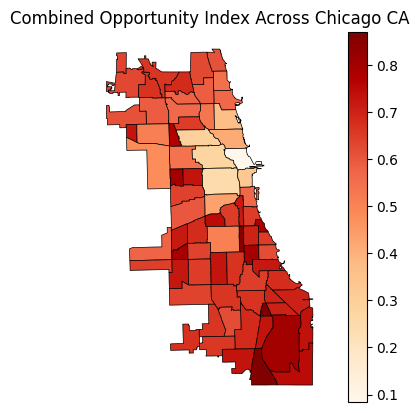

,ca_num,ca_name,business_license_count,food_inspections_count,liquor_license_count,building_permits_count,pct_dependents,pct_working_age,per_capita_income,hardship_index,...,school_need,schools_undersupply_raw,schools_undersupply,bars_need,bars_undersupply_raw,bars_undersupply,shop_need,shops_undersupply_raw,shops_undersupply,combined_opportunity_index
76,47,BURNSIDE,0.0,0.0,0.0,1.0,42.700000,57.300000,12515.000000,79.000000,...,42.700000,42.700000,0.951002,57.300000,57.300000,0.822144,60.883158,60.883158,0.865141,0.869407
74,54,RIVERDALE,1.0,0.0,0.0,2.0,51.500000,48.500000,8201.000000,98.000000,...,51.500000,42.543478,0.947516,48.500000,48.500000,0.695881,70.373684,70.373684,1.000000,0.865231
65,37,FULLER PARK,2.0,5.0,1.0,1.0,44.900000,55.100000,10432.000000,97.000000,...,44.900000,44.900000,1.000000,55.100000,54.717361,0.785088,65.361053,58.599564,0.832691,0.855477
49,51,SOUTH DEERING,4.0,4.0,2.0,7.0,39.500000,60.500000,14685.000000,65.000000,...,39.500000,36.065217,0.803234,60.500000,59.659722,0.856001,55.278947,51.466606,0.731333,0.799176
67,26,WEST GARFIELD PARK,2.0,2.0,1.0,2.0,43.600000,56.400000,10934.000000,92.000000,...,43.600000,34.121739,0.759950,56.400000,56.008333,0.803611,64.054737,57.428385,0.816049,0.797049
72,40,WASHINGTON PARK,0.0,1.0,3.0,5.0,42.800000,57.200000,13785.000000,88.000000,...,42.800000,33.495652,0.746006,57.200000,56.008333,0.803611,57.785263,57.785263,0.821120,0.795338
50,62,WEST ELSDON,4.0,6.0,3.0,2.0,37.700000,62.300000,15754.000000,69.000000,...,37.700000,34.421739,0.766631,62.300000,61.002083,0.875262,52.093684,50.297350,0.714718,0.791914
75,36,OAKLAND,0.0,0.0,0.0,1.0,40.400000,59.600000,19252.000000,78.000000,...,40.400000,38.643478,0.860657,59.600000,59.600000,0.855144,46.345263,46.345263,0.658560,0.787718
38,20,HERMOSA,5.0,14.0,3.0,0.0,36.400000,63.600000,15089.000000,71.000000,...,36.400000,30.069565,0.669701,63.600000,62.275000,0.893525,52.892632,49.244864,0.699762,0.769752
68,55,HEGEWISCH,1.0,3.0,4.0,0.0,42.900000,57.100000,22677.000000,44.000000,...,42.900000,41.034783,0.913915,57.100000,55.513889,0.796517,45.213684,40.536407,0.576017,0.748691


In [73]:
# -----------------------------------------------------------
# 8. Choropleth map of combined opportunity index
# -----------------------------------------------------------

plt.figure(figsize=(12, 10))
gdf.plot(
    column="combined_opportunity_index",
    cmap="OrRd",
    legend=True,
    edgecolor="black",
    linewidth=0.5
)
plt.title("Combined Opportunity Index Across Chicago CA")
plt.axis("off")
plt.savefig("mapa_oportunidad_index.png", bbox_inches='tight', dpi=300)

plt.show()

# Save output
df.to_csv("../datasets/combined_opportunity_index_by_CA.csv", index=False)

df.sort_values("combined_opportunity_index", ascending=False).head(20)


In [71]:
# print all the info of burnside

print(df[df['ca_name'] == 'NEAR SOUTH SIDE'].to_string())
print(df[df['ca_name'] == 'MONTCLARE'].to_string())
print(df[df['ca_name'] == 'OAKLAND'].to_string())
print(df[df['ca_name'] == 'BURNSIDE'].to_string())

    ca_num          ca_name  business_license_count  food_inspections_count  liquor_license_count  building_permits_count  pct_dependents  pct_working_age  per_capita_income  hardship_index  scaled_business_license_count  scaled_food_inspections_count  scaled_liquor_license_count  scaled_building_permits_count  saturation_index  retail_count  school_count  scaled_retail_count  scaled_school_count  school_need  schools_undersupply_raw  schools_undersupply  bars_need  bars_undersupply_raw  bars_undersupply  shop_need  shops_undersupply_raw  shops_undersupply  combined_opportunity_index
24      33  NEAR SOUTH SIDE                     2.0                    14.0                  17.0                    12.0            21.8             78.2            59077.0             7.0                       0.047619                       0.179487                     0.118056                       0.108108          0.113815           2.0             4             0.068966             0.130435         2

In [74]:
df.sort_values("combined_opportunity_index", ascending=True).head(1)


,ca_num,ca_name,business_license_count,food_inspections_count,liquor_license_count,building_permits_count,pct_dependents,pct_working_age,per_capita_income,hardship_index,...,school_need,schools_undersupply_raw,schools_undersupply,bars_need,bars_undersupply_raw,bars_undersupply,shop_need,shops_undersupply_raw,shops_undersupply,combined_opportunity_index
0,8,NEAR NORTH SIDE,33.0,78.0,144.0,111.0,22.6,77.4,88669.0,1.0,...,22.6,14.73913,0.328266,77.4,0.0,0.0,13.56,0.467586,0.006644,0.084392
